In [9]:
%%capture

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, GRU, LSTM, BatchNormalization
from tensorflow.keras.layers import Dropout, Dense, SimpleRNN
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from gensim.models import Word2Vec
from keras.utils.data_utils import get_file

import numpy as np


import os
import time
from tqdm import tqdm

import re

import nltk
nltk.download('all')

import matplotlib
from matplotlib import pyplot as plt


In [10]:
"""
'zapiskiw.txt', 
'r_bakenshik.txt',
'gulag.txt',
'griby.txt',
'azazel.txt',
'3rdflare.txt',
'grossman10.txt',
'monah.txt',
'bonapart.txt',
'kladsoln.txt'

'http://lib.ru/BULGAKOW/zapiskiw.txt',
'http://lib.ru/PROZA/PAUSTOWSKIJ/r_bakenshik.txt',
'http://lib.ru/PROZA/SOLZHENICYN/gulag.txt',
'http://lib.ru/PROZA/SOLOUHIN/griby.txt',
'http://lib.ru/RUSS_DETEKTIW/BAKUNIN/azazel.txt',
'http://lib.ru/PROZA/BYKOW/3rdflare.txt',
'http://lib.ru/PROZA/GROSSMAN/grossman10.txt',
'http://lib.ru/KOWAL/monah.txt',
'http://lib.ru/PROZA/OKUDZHAWA/bonapart.txt',
'http://lib.ru/PRISHWIN/kladsoln.txt'
"""

"\n'zapiskiw.txt', \n'r_bakenshik.txt',\n'gulag.txt',\n'griby.txt',\n'azazel.txt',\n'3rdflare.txt',\n'grossman10.txt',\n'monah.txt',\n'bonapart.txt',\n'kladsoln.txt'\n\n'http://lib.ru/BULGAKOW/zapiskiw.txt',\n'http://lib.ru/PROZA/PAUSTOWSKIJ/r_bakenshik.txt',\n'http://lib.ru/PROZA/SOLZHENICYN/gulag.txt',\n'http://lib.ru/PROZA/SOLOUHIN/griby.txt',\n'http://lib.ru/RUSS_DETEKTIW/BAKUNIN/azazel.txt',\n'http://lib.ru/PROZA/BYKOW/3rdflare.txt',\n'http://lib.ru/PROZA/GROSSMAN/grossman10.txt',\n'http://lib.ru/KOWAL/monah.txt',\n'http://lib.ru/PROZA/OKUDZHAWA/bonapart.txt',\n'http://lib.ru/PRISHWIN/kladsoln.txt'\n"

# Считывание книги



In [11]:
def read_text(book, url):
  text = ''
  path = get_file(book, origin=url)    
  with open(path, 'rb') as f:
      text = f.read().decode(encoding='koi8-r')
  return text

In [12]:
text = read_text('azazel.txt', 'http://lib.ru/RUSS_DETEKTIW/BAKUNIN/azazel.txt')

 401408/Unknown - 0s 1us/step

# Очистка книги от html тегов

In [13]:
def clear_html(text):
  res = text
  res = res.replace('<pre>', '', 1)
  res = res[res.find('<pre>'):]
  res = res.replace('<pre>', '', 1)
  res = res[:res.find('<pre>')]
  res = res[res.find('Евгений Морозов'):]

  to_del = ['\n', '\t', 'x x x', '-']
  for d in to_del:
    res = res.replace(d, ' ')

  t = res
  res = []

  while '</ul>' in t:
    t = t.replace('<ul>', '', 1)
    t_ = t[t.find('</ul>'):t.find('<ul>')]
    res.append(t_.replace('</ul>', '', 1)) 
    t = t[t.find('<ul>'):]  

  for s in res:
    if (s == '') | (s == '   ') | (s == '    '):
      res.remove(s)
  return res

In [14]:
t = clear_html(text)

# Создание последовательностей

In [15]:
def make_tokens(text):
  res = []
  tags = nltk.pos_tag(nltk.word_tokenize(text))
  for tag in tags:
      if tag[1] != 'NNP':
          res.append(tag[0].lower())
      else:
          res.append(tag[0])
  return res

In [16]:
def make_seqs(text, lenght=50):
  ch_seqs = []
  seqs = []
  for chap in text:
    tokens = make_tokens(chap)
    i = 0
    for j in range(lenght, len(tokens), lenght):
      ch_seqs.append(tokens[i:j])
      i = j
    seqs.extend(ch_seqs)
  return seqs

In [17]:
seqs = make_seqs(t)

# Приведение к типу Word2Vec

In [18]:
w2v = Word2Vec(seqs, min_count=2, size = 510, workers = 4, iter = 27, alpha = 0.1)

# Создание взаимооднозначных словарей

In [19]:
def make_vocabs(w2v):
  ind = 0
  w_i = {}
  i_w = {}
  for w in w2v.wv.vocab:
    w_i[w] = ind
    i_w[ind] = w
    ind += 1
  return w_i, i_w

In [20]:
word_inds_vocab, inds_word_vocab = make_vocabs(w2v)

# Перевод на язык чисел

In [21]:
def translate_word(w, w_i):
  if w in w_i:
    return w_i[w]
  return w_i[',']

In [22]:
def translate_text(seqs, w_i):
  res = []
  for seq in tqdm(seqs):
    res.append(list(map(lambda x: translate_word(x, w_i), seq)))
  return res

In [23]:
data = tf.data.Dataset.from_tensor_slices(translate_text(seqs, word_inds_vocab))
data

100%|██████████| 19728/19728 [00:00<00:00, 79810.98it/s]


<TensorSliceDataset shapes: (50,), types: tf.int32>

# Деление на обучающую и тестовую последовательности

In [24]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [25]:
dataset = data.map(split_input_target)
dataset

<MapDataset shapes: ((49,), (49,)), types: (tf.int32, tf.int32)>

# Создание батчей

In [26]:
dataset = dataset.shuffle(10000).batch(128, drop_remainder=True)
dataset

<BatchDataset shapes: ((128, 49), (128, 49)), types: (tf.int32, tf.int32)>

# Проектирование моделей


# SimpleRNN

In [27]:
RNN_DIR = "./rnn"

In [28]:
! mkdir -p rnn

In [29]:
def ModelRNN(w2v, batch_size, rnn_units = 256, neuros = 64, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        SimpleRNN(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")   
    ])
    #optimizer = RMSprop(learning_rate=0.01)
    #model.compile(loss='categorical_crossentropy', optimizer=optimizer)
    return model

# 1 Layer LSTM

In [30]:
LSTM_1_DIR = "./lstm_1"

In [31]:
! mkdir -p lstm_1

In [32]:
def ModelLSTM_1(w2v, batch_size, rnn_units = 256, neuros = 64, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

# 2 Layers LSTM

In [33]:
LSTM_2_DIR = "./lstm_2"

In [34]:
! mkdir -p lstm_2

In [35]:
def ModelLSTM_2(w2v, batch_size, rnn_units = 256, neuros = 64, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        LSTM(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'),
      # 4 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

# GRU

In [36]:
GRU_DIR = "./gru"

In [37]:
! mkdir -p gru

In [38]:
def ModelGRU(w2v, batch_size, rnn_units = 256, neuros = 64, drop_rate = 0.1):
    vocab_size = len(w2v.wv.vocab)
    model = Sequential([
      # 1 layer
        Embedding(vocab_size, w2v.vector_size, 
                  batch_input_shape=[batch_size, None], weights=[w2v.wv.vectors]),
      # 2 layer 
        GRU(rnn_units, return_sequences=True, stateful=False, 
          recurrent_initializer='glorot_uniform'), 
      # 3 layer
        Dense(vocab_size, kernel_initializer="glorot_uniform")
    ])
    return model

# Чекпоинты

In [39]:
def checkpoint_creator(checkpoint_dir = "./"):
    checkpoint_prefix = os.path.join(checkpoint_dir, "checkpoints/ckpt_model")
    checkpoint_callback = ModelCheckpoint(monitor="loss", 
                                          filepath=checkpoint_prefix,
                                          save_weights_only=True, 
                                          save_best_only=True)
    return checkpoint_callback

# Кросс-энтропия

In [40]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

# Создание моделей

In [41]:
print("RNN")
rnn = ModelRNN(w2v, 128)
rnn.summary()

RNN
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (128, None, 510)          8457840   
_________________________________________________________________
simple_rnn (SimpleRNN)       (128, None, 256)          196352    
_________________________________________________________________
dense (Dense)                (128, None, 16584)        4262088   
Total params: 12,916,280
Trainable params: 12,916,280
Non-trainable params: 0
_________________________________________________________________


In [42]:
print("1 LAYER LSTM")
lstm_1 = ModelLSTM_1(w2v, 128)
lstm_1.summary()

1 LAYER LSTM
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (128, None, 510)          8457840   
_________________________________________________________________
lstm (LSTM)                  (128, None, 256)          785408    
_________________________________________________________________
dense_1 (Dense)              (128, None, 16584)        4262088   
Total params: 13,505,336
Trainable params: 13,505,336
Non-trainable params: 0
_________________________________________________________________


In [43]:
print("2 LAYERS LSTM")
lstm_2 = ModelLSTM_2(w2v, 128)
lstm_2.summary()

2 LAYERS LSTM
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (128, None, 510)          8457840   
_________________________________________________________________
lstm_1 (LSTM)                (128, None, 256)          785408    
_________________________________________________________________
lstm_2 (LSTM)                (128, None, 256)          525312    
_________________________________________________________________
dense_2 (Dense)              (128, None, 16584)        4262088   
Total params: 14,030,648
Trainable params: 14,030,648
Non-trainable params: 0
_________________________________________________________________


In [44]:
print("GRU")
gru = ModelGRU(w2v, 128)
gru.summary()

GRU
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (128, None, 510)          8457840   
_________________________________________________________________
gru (GRU)                    (128, None, 256)          589824    
_________________________________________________________________
dense_3 (Dense)              (128, None, 16584)        4262088   
Total params: 13,309,752
Trainable params: 13,309,752
Non-trainable params: 0
_________________________________________________________________


# Обучение моделей

## RNN


In [45]:
rnn.compile(optimizer='adam', loss=loss)
my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(RNN_DIR)]
rnn_hist = rnn.fit(dataset, epochs=60, callbacks=my_callbacks)

Epoch 1/60
154/154 [==============================] - 21s 135ms/step - loss: 6.7665
Epoch 2/60
154/154 [==============================] - 21s 134ms/step - loss: 4.5722
Epoch 3/60
154/154 [==============================] - 21s 134ms/step - loss: 2.9447
Epoch 4/60
154/154 [==============================] - 21s 135ms/step - loss: 1.8597
Epoch 5/60
154/154 [==============================] - 21s 136ms/step - loss: 1.1635
Epoch 6/60
154/154 [==============================] - 21s 134ms/step - loss: 0.7438
Epoch 7/60
154/154 [==============================] - 21s 134ms/step - loss: 0.4937
Epoch 8/60
154/154 [==============================] - 21s 134ms/step - loss: 0.3447
Epoch 9/60
154/154 [==============================] - 21s 134ms/step - loss: 0.2526
Epoch 10/60
154/154 [==============================] - 21s 134ms/step - loss: 0.1927
Epoch 11/60
154/154 [==============================] - 21s 134ms/step - loss: 0.1535
Epoch 12/60
154/154 [==============================] - 21s 134ms/step - lo

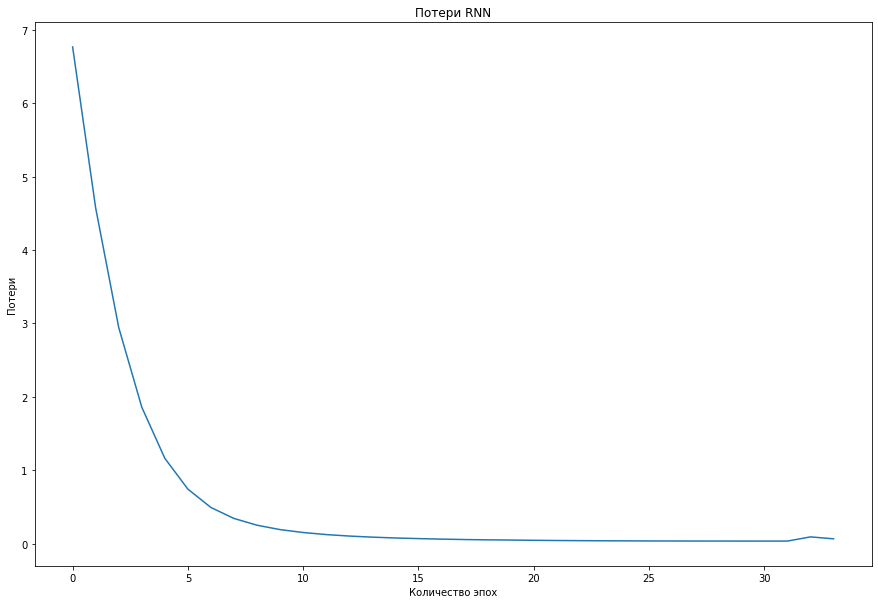

In [46]:
fig = plt.figure(figsize=(15, 10))
plt.title('Потери RNN')
plt.plot(rnn_hist.history['loss'])
plt.ylabel('Потери')
plt.xlabel('Количество эпох')
plt.show()

## 1 Layer LSTM

In [47]:
lstm_1.compile(optimizer='adam', loss=loss)
my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(LSTM_1_DIR)]
lstm_1_hist = lstm_1.fit(dataset, epochs=60, callbacks=my_callbacks)

Epoch 1/60
154/154 [==============================] - 20s 133ms/step - loss: 7.2658
Epoch 2/60
154/154 [==============================] - 20s 130ms/step - loss: 6.1691
Epoch 3/60
154/154 [==============================] - 20s 131ms/step - loss: 5.2223
Epoch 4/60
154/154 [==============================] - 20s 131ms/step - loss: 4.4048
Epoch 5/60
154/154 [==============================] - 20s 131ms/step - loss: 3.7453
Epoch 6/60
154/154 [==============================] - 20s 131ms/step - loss: 3.2705
Epoch 7/60
154/154 [==============================] - 20s 131ms/step - loss: 2.9179
Epoch 8/60
154/154 [==============================] - 20s 131ms/step - loss: 2.6196
Epoch 9/60
154/154 [==============================] - 20s 131ms/step - loss: 2.3421
Epoch 10/60
154/154 [==============================] - 20s 130ms/step - loss: 2.0719
Epoch 11/60
154/154 [==============================] - 20s 130ms/step - loss: 1.8100
Epoch 12/60
154/154 [==============================] - 20s 131ms/step - lo

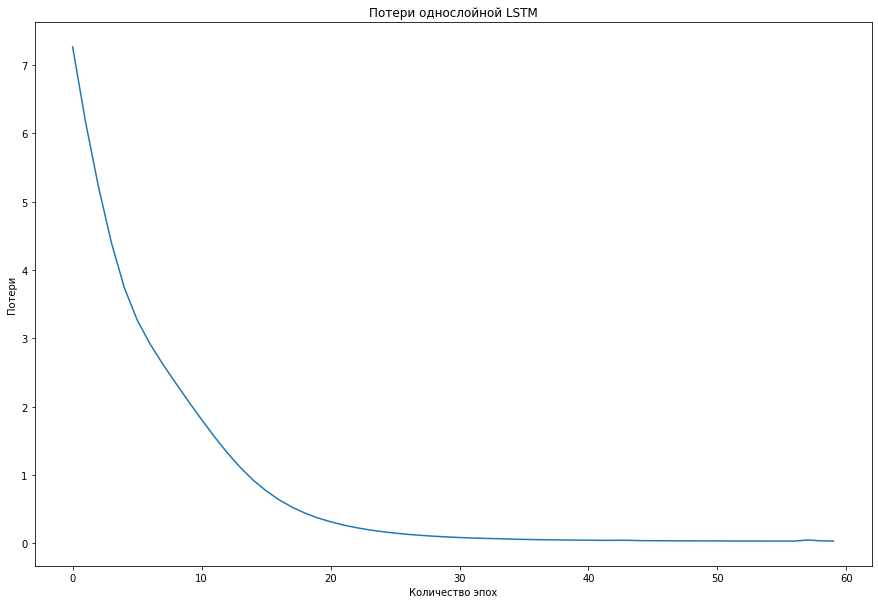

In [48]:
fig = plt.figure(figsize=(15, 10))
plt.title('Потери однослойной LSTM')
plt.plot(lstm_1_hist.history['loss'])
plt.ylabel('Потери')
plt.xlabel('Количество эпох')
plt.show()

## 2 Layers LSTM

In [49]:
lstm_2.compile(optimizer='adam', loss=loss)
my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(LSTM_2_DIR)]
lstm_2_hist = lstm_2.fit(dataset, epochs=60, callbacks=my_callbacks)

Epoch 1/60
154/154 [==============================] - 21s 138ms/step - loss: 7.4255
Epoch 2/60
154/154 [==============================] - 21s 137ms/step - loss: 7.2331
Epoch 3/60
154/154 [==============================] - 21s 136ms/step - loss: 7.2231
Epoch 4/60
154/154 [==============================] - 21s 137ms/step - loss: 7.1760
Epoch 5/60
154/154 [==============================] - 21s 137ms/step - loss: 6.7557
Epoch 6/60
154/154 [==============================] - 21s 136ms/step - loss: 6.2018
Epoch 7/60
154/154 [==============================] - 21s 137ms/step - loss: 5.5905
Epoch 8/60
154/154 [==============================] - 21s 137ms/step - loss: 4.8102
Epoch 9/60
154/154 [==============================] - 21s 136ms/step - loss: 3.9453
Epoch 10/60
154/154 [==============================] - 21s 137ms/step - loss: 3.1176
Epoch 11/60
154/154 [==============================] - 21s 137ms/step - loss: 2.3991
Epoch 12/60
154/154 [==============================] - 21s 137ms/step - lo

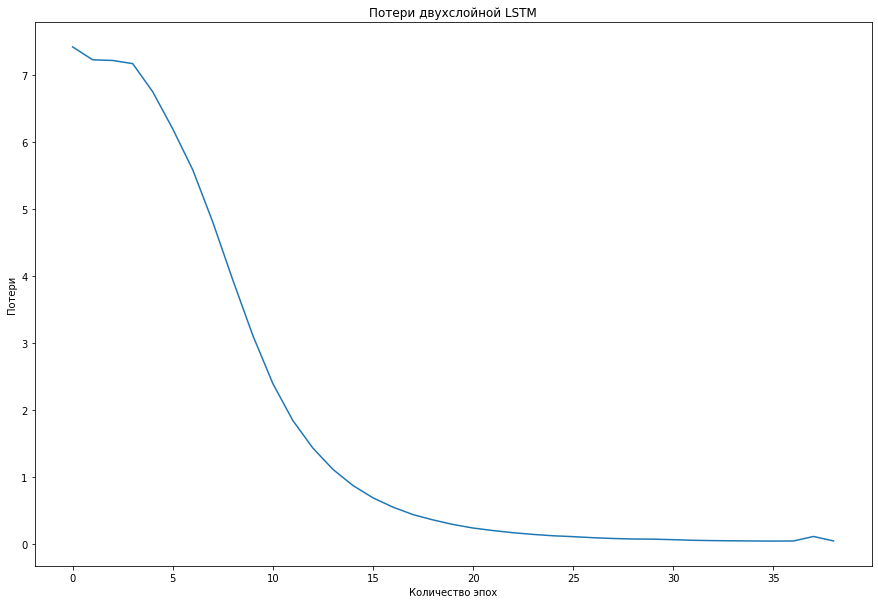

In [50]:
fig = plt.figure(figsize=(15, 10))
plt.title('Потери двухслойной LSTM')
plt.plot(lstm_2_hist.history['loss'])
plt.ylabel('Потери')
plt.xlabel('Количество эпох')
plt.show()

## GRU

In [51]:
gru.compile(optimizer='adam', loss=loss)
my_callbacks = [EarlyStopping(monitor="loss", patience=3), checkpoint_creator(GRU_DIR)]
gru_hist = gru.fit(dataset, epochs=60, callbacks=my_callbacks)

Epoch 1/60
154/154 [==============================] - 20s 132ms/step - loss: 7.0189
Epoch 2/60
154/154 [==============================] - 20s 131ms/step - loss: 5.2030
Epoch 3/60
154/154 [==============================] - 20s 130ms/step - loss: 3.2642
Epoch 4/60
154/154 [==============================] - 20s 131ms/step - loss: 2.1326
Epoch 5/60
154/154 [==============================] - 20s 131ms/step - loss: 1.4781
Epoch 6/60
154/154 [==============================] - 20s 131ms/step - loss: 1.0467
Epoch 7/60
154/154 [==============================] - 20s 130ms/step - loss: 0.7485
Epoch 8/60
154/154 [==============================] - 20s 131ms/step - loss: 0.5433
Epoch 9/60
154/154 [==============================] - 20s 131ms/step - loss: 0.4010
Epoch 10/60
154/154 [==============================] - 20s 131ms/step - loss: 0.3038
Epoch 11/60
154/154 [==============================] - 20s 131ms/step - loss: 0.2357
Epoch 12/60
154/154 [==============================] - 20s 132ms/step - lo

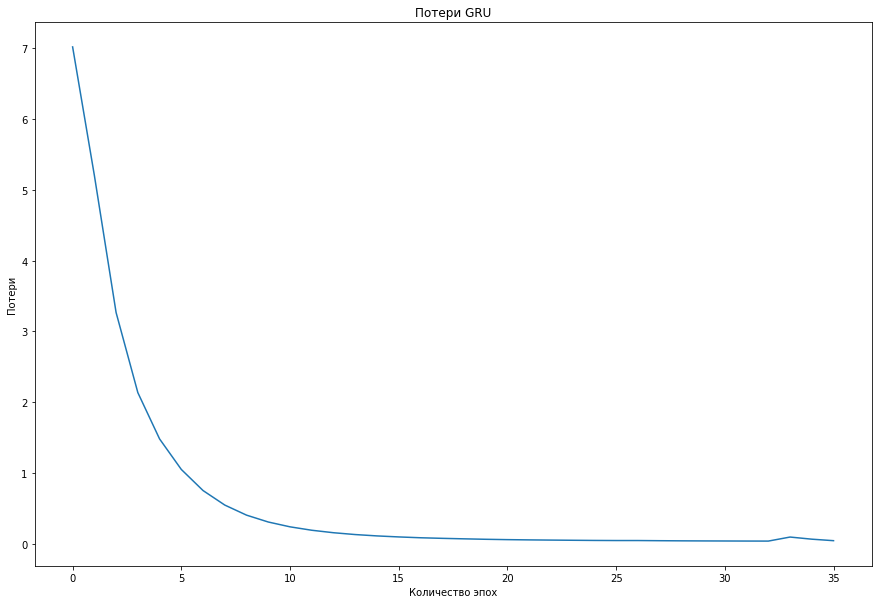

In [52]:
fig = plt.figure(figsize=(15, 10))
plt.title('Потери GRU')
plt.plot(gru_hist.history['loss'])
plt.ylabel('Потери')
plt.xlabel('Количество эпох')
plt.show()

# Создание моделей для генерации

In [53]:
checkpoint_dir = os.path.join(RNN_DIR, "checkpoints/")

_rnn = ModelRNN(w2v, 1)
_rnn.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
_rnn.build(tf.TensorShape([1, None]))

filename = os.path.join(RNN_DIR, "_rnn.h5")
_rnn.save(filename)

In [62]:
checkpoint_dir = os.path.join(LSTM_1_DIR, "checkpoints/")

_lstm_1 = ModelLSTM_1(w2v, 1)
_lstm_1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
_lstm_1.build(tf.TensorShape([1, None]))

filename = os.path.join(LSTM_1_DIR, "_lstm_1.h5")
_lstm_1.save(filename)

In [63]:
checkpoint_dir = os.path.join(LSTM_2_DIR, "checkpoints/")

_lstm_2 = ModelLSTM_2(w2v, 1)
_lstm_2.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
_lstm_2.build(tf.TensorShape([1, None]))

filename = os.path.join(LSTM_2_DIR, "_lstm_2.h5")
_lstm_2.save(filename)

In [64]:
checkpoint_dir = os.path.join(GRU_DIR, "checkpoints/")

_gru = ModelGRU(w2v, 1)
_gru.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
_gru.build(tf.TensorShape([1, None]))

filename = os.path.join(GRU_DIR, "_gru.h5")
_gru.save(filename)

# Перевод текста с численного языка на словесный

In [78]:
def generate_text(model, w_i, i_w, string, num_generate=30):
  seq = make_tokens(string)
  input_eval = list(map(lambda x: translate_word(x, w_i), seq))
  input_eval = tf.expand_dims(input_eval, 0)
  text_generated = []
  temperature = 1.25
  model.reset_states()

  for i in range(num_generate):
      predictions = model(input_eval)
      predictions = tf.squeeze(predictions, 0)
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      input_eval = tf.expand_dims([predicted_id], 0)
      text_generated.append(i_w[predicted_id])

  return string + ' '.join(text_generated)

# Генерация RNN

In [79]:
generate_text(_rnn, word_inds_vocab, inds_word_vocab, "Сегодня хорошая погода")

'Сегодня хорошая погода, спортсмены и удалилась в сторону , но не трус , но как ? спросил , однако позвольте узнать за нас не видел , скорее риторический , самый раз было'

# Генерация однослойной LSTM

In [80]:
generate_text(_lstm_1, word_inds_vocab, inds_word_vocab, "Сегодня хорошая погода")

'Сегодня хорошая погода, но проклятая какой уж объяснить . мокну . ну что примерещилось . кажется , чтобы в оперетке , в нем так ! прошипела храбрая свидетельство маршрутную `` азазель ,'

# Генерация двухслойной LSTM

In [81]:
generate_text(_lstm_2, word_inds_vocab, inds_word_vocab, "Сегодня хорошая погода")

'Сегодня хорошая погода. я тебе адрес крови невдомек . это лицо мужа управления ласковый . банкомет двери жестоко отпили человек . но ведь обошлось , а кроме втором два счета : ``'

# Генерация GRU

In [82]:
generate_text(_gru, word_inds_vocab, inds_word_vocab, "Сегодня хорошая погода")

'Сегодня хорошая погода, Амалия бога понял добрый . тут то додумался счет . раскрыв друг мой ориентацию как вытащиться , еще садитесь дорогой перчаток перчаток вас одни границей что отдал знакомство затаился'

In [83]:
rm -rf rnn lstm_1 lstm_2 gru